In [25]:
# Import things that are needed generically
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode
# from langchain_openai.chat_models.base import _convert_message_to_dict
from langchain_core.messages import SystemMessage
from typing import Optional

class SearchInput(BaseModel):
    query: str = Field(description="a detailed sentence for efficient search")

class WeatherInput(BaseModel):
    location: str = Field(description="The city and state, e.g. San Francisco, CA")
    unit: str = Field(enum=["celsius", "fahrenheit"])

@tool("search_online", args_schema=SearchInput)
def search(query: str):
    """An online search tool to retrieve the most accurate and up-to-date, lastest information available."""

    tool = TavilySearchResults(max_results=2)
    results = tool.invoke(query) 
    content = '\n\n'.join([f"{index+1}. {i['content']}" for index, i in enumerate(results)])

    return content

@tool("get_current_weather", args_schema=WeatherInput)
def get_weather(location: str, unit:str):
    """This function retrieves the latest weather information for a specified location. """

    return f"Now the weather in {location} is 22 {unit}"

In [26]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor([search, get_weather])

In [27]:
import multiprocessing
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_community.chat_models import ChatLlamaCpp
from llamacpp_function_calling.chat_format import hermes_pro_function_calling


model = ChatLlamaCpp(
    temperature = 0.5,
    model_path = "/Users/thanhnguyen/Documents/Developer/llamacpp_function_calling/models/Hermes-2-Pro-Llama-3-8B-Q8_0.gguf",
    n_ctx = 10000,
    n_gpu_layers = 20,
    n_batch = 850,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_threads = multiprocessing.cpu_count()-5,
    # callback_manager = CallbackManager([StreamingStdOutCallbackHandler()]),# Callbacks support token-wise streaming
    max_tokens = 512,
    verbose= True,
    chat_handler=hermes_pro_function_calling
)

llama_model_loader: loaded meta data with 23 key-value pairs and 291 tensors from /Users/thanhnguyen/Documents/Developer/llamacpp_function_calling/models/Hermes-2-Pro-Llama-3-8B-Q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = Hermes-2-Pro-Llama-3-8B
llama_model_loader: - kv   2:                          llama.block_count u32              = 32
llama_model_loader: - kv   3:                       llama.context_length u32              = 8192
llama_model_loader: - kv   4:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.attention.head_count u32          

In [28]:
model = model.bind_tools(tools=[search, get_weather],
                         tool_choice='auto')
                         

In [30]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [31]:
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolInvocation


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function to execute tools
def call_tool(state):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_call = last_message.tool_calls[0]
    action = ToolInvocation(
        tool=tool_call["name"],
        tool_input=tool_call["args"],
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = ToolMessage(
        content=str(response), name=action.tool, tool_call_id=tool_call["id"]
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

In [32]:
from langgraph.graph import END, StateGraph, START

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

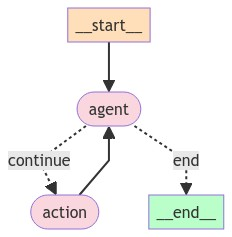

In [33]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [34]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="hello, who are you")]}
app.invoke(inputs)

/opt/anaconda3/envs/agent1/lib/python3.10/site-packages/llama_cpp/llama.py:1054: RuntimeWarning: Detected duplicate leading "<|begin_of_text|>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
Llama.generate: prefix-match hit

llama_print_timings:        load time =    2222.61 ms
llama_print_timings:      sample time =      14.71 ms /    22 runs   (    0.67 ms per token,  1495.58 tokens per second)
llama_print_timings: prompt eval time =     195.03 ms /     9 tokens (   21.67 ms per token,    46.15 tokens per second)
llama_print_timings:        eval time =    1137.54 ms /    21 runs   (   54.17 ms per token,    18.46 tokens per second)
llama_print_timings:       total time =    1357.38 ms /    30 tokens


{'messages': [HumanMessage(content='hello, who are you'),
  AIMessage(content='\nI am an AI language model designed to assist with various tasks. How may I help you today?', response_metadata={'token_usage': {'prompt_tokens': 349, 'completion_tokens': 21, 'total_tokens': 370}, 'finish_reason': 'stop', 'logprobs': None}, id='run-66abe59b-a677-4202-853e-f833d68ebf4c-0')]}

In [35]:
inputs = {"messages": [HumanMessage(content="what is the weather in hcm in celsius")]}
app.invoke(inputs)

/opt/anaconda3/envs/agent1/lib/python3.10/site-packages/llama_cpp/llama.py:1054: RuntimeWarning: Detected duplicate leading "<|begin_of_text|>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
Llama.generate: prefix-match hit

llama_print_timings:        load time =    2222.61 ms
llama_print_timings:      sample time =      21.50 ms /    30 runs   (    0.72 ms per token,  1395.35 tokens per second)
llama_print_timings: prompt eval time =     242.96 ms /    14 tokens (   17.35 ms per token,    57.62 tokens per second)
llama_print_timings:        eval time =    1574.27 ms /    29 runs   (   54.29 ms per token,    18.42 tokens per second)
llama_print_timings:       total time =    1852.19 ms /    43 tokens
/opt/anaconda3/envs/agent1/lib/python3.10/site-packages/llama_cpp/llama.py:1054: RuntimeWarning: Detected duplicate leading "<|begin_of_text|>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
Llam

[{'name': 'get_current_weather', 'args': {'location': 'HCM', 'unit': 'celsius'}, 'id': 'call__0_get_current_weather_cmpl-b260feef-bf26-4991-8d56-9286acfe3d66'}]



llama_print_timings:        load time =    2222.61 ms
llama_print_timings:      sample time =      14.45 ms /    20 runs   (    0.72 ms per token,  1384.18 tokens per second)
llama_print_timings: prompt eval time =     337.03 ms /    26 tokens (   12.96 ms per token,    77.14 tokens per second)
llama_print_timings:        eval time =    1039.03 ms /    19 runs   (   54.69 ms per token,    18.29 tokens per second)
llama_print_timings:       total time =    1400.27 ms /    45 tokens


{'messages': [HumanMessage(content='what is the weather in hcm in celsius'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call__0_get_current_weather_cmpl-b260feef-bf26-4991-8d56-9286acfe3d66', 'type': 'function', 'function': {'name': 'get_current_weather', 'arguments': '{"location": "HCM", "unit": "celsius"}'}}]}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 354, 'total_tokens': 383}, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-649dc744-dcde-46b3-9f16-f51cd362726f-0', tool_calls=[{'name': 'get_current_weather', 'args': {'location': 'HCM', 'unit': 'celsius'}, 'id': 'call__0_get_current_weather_cmpl-b260feef-bf26-4991-8d56-9286acfe3d66'}]),
  ToolMessage(content='Now the weather in HCM is 22 celsius', name='get_current_weather', tool_call_id='call__0_get_current_weather_cmpl-b260feef-bf26-4991-8d56-9286acfe3d66'),
  AIMessage(content='\nThe current temperature in Ho Chi Minh City (HCM) is 22 degrees Celsius.', response_m

In [36]:
inputs = {"messages": [HumanMessage(content="which team won final nba 2024 ?")]}
app.invoke(inputs)

/opt/anaconda3/envs/agent1/lib/python3.10/site-packages/llama_cpp/llama.py:1054: RuntimeWarning: Detected duplicate leading "<|begin_of_text|>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
Llama.generate: prefix-match hit

llama_print_timings:        load time =    2222.61 ms
llama_print_timings:      sample time =      20.23 ms /    28 runs   (    0.72 ms per token,  1384.29 tokens per second)
llama_print_timings: prompt eval time =     247.31 ms /    14 tokens (   17.67 ms per token,    56.61 tokens per second)
llama_print_timings:        eval time =    1466.68 ms /    27 runs   (   54.32 ms per token,    18.41 tokens per second)
llama_print_timings:       total time =    1746.45 ms /    41 tokens


[{'name': 'search_online', 'args': {'query': 'NBA Finals winner in 2024'}, 'id': 'call__0_search_online_cmpl-657aaaf4-178e-486d-99f6-2fb17295ce3f'}]


/opt/anaconda3/envs/agent1/lib/python3.10/site-packages/llama_cpp/llama.py:1054: RuntimeWarning: Detected duplicate leading "<|begin_of_text|>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
Llama.generate: prefix-match hit

llama_print_timings:        load time =    2222.61 ms
llama_print_timings:      sample time =      44.76 ms /    67 runs   (    0.67 ms per token,  1496.87 tokens per second)
llama_print_timings: prompt eval time =    1152.42 ms /   113 tokens (   10.20 ms per token,    98.05 tokens per second)
llama_print_timings:        eval time =    3634.31 ms /    66 runs   (   55.07 ms per token,    18.16 tokens per second)
llama_print_timings:       total time =    4868.41 ms /   179 tokens


{'messages': [HumanMessage(content='which team won final nba 2024 ?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call__0_search_online_cmpl-657aaaf4-178e-486d-99f6-2fb17295ce3f', 'type': 'function', 'function': {'name': 'search_online', 'arguments': '{"query": "NBA Finals winner in 2024"}'}}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 354, 'total_tokens': 381}, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9d255a96-67e5-4fe9-ad65-7ceeb361585c-0', tool_calls=[{'name': 'search_online', 'args': {'query': 'NBA Finals winner in 2024'}, 'id': 'call__0_search_online_cmpl-657aaaf4-178e-486d-99f6-2fb17295ce3f'}]),
  ToolMessage(content="1. Celtics' Brown named 2024 Finals MVP. Brown averages 20.8 points, 5.4 rebounds and 5.0 assists with quality defense in the NBA Finals presented by YouTube TV.Schedule · Latest Finals News · 2024 NBA Playoffs Bracket · NBA Season Recaps\n\n2. The Celtics defeated the Mavericks four games t